In [1]:
import torch
from torchvision.io import read_image
from torchvision.transforms.functional import rgb_to_grayscale
import numpy as np
import shared.data_utils as data_utils
import modules
from contextlib import nullcontext

def get_image(img_dir, label):
    img = read_image(img_dir)
    # the background will need to be masked if using other images because
    # this assumes a constant background colour
    mask = data_utils.background_mask(np.array(img))
    mesh_dict = {'image': (rgb_to_grayscale(img[0:3]) * mask).unsqueeze(0), 'class_label': torch.tensor(label).unsqueeze(0)}

    return mesh_dict
        
class_labels = {'bench': 0, 'chair': 1, 'table': 2}

random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
batch_size = 1
compile = False 
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
device_type = 'cuda'
device = torch.device(device_type)
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.autocast(device_type=device_type, dtype=ptdtype)

In [2]:

config = torch.load('./pretrained_weights/config.pt') # model config
quantization_bits = 8

# Create vertex model
vertex_model = modules.ImageToVertexModel(
    decoder_config=config["vertex_decoder_config"],
    res_net_config=config["res_net_config"],
    max_num_input_verts=config["max_num_input_verts"],
    quantization_bits=quantization_bits,
    class_conditional=True,
    num_classes=len(class_labels),
    device=device
).to(device=device)

# Create face model
face_model = modules.FaceModel(
    encoder_config=config["face_encoder_config"],
    decoder_config=config["face_decoder_config"],
    class_conditional=False,
    max_seq_length=config["max_num_face_sequence"],
    quantization_bits=quantization_bits,
    max_num_input_verts=config["max_num_input_verts"],
    decoder_cross_attention=True,
    use_discrete_vertex_embeddings=True,
    device=device
).to(device=device)

# compile the model

if compile:
    # requires PyTorch 2.0 and Linux
    print("compiling the model... (takes a ~minute)")
    vertex_model = torch.compile(vertex_model, dynamic=True)
    face_model = torch.compile(face_model, dynamic=True)

n_samples = 1
scaler = torch.cuda.amp.GradScaler(enabled=device_type == 'cuda')

chkpt = torch.load('./pretrained_weights/ckpt.pt')
vertex_model.load_state_dict(chkpt['vertex_model'])
face_model.load_state_dict(chkpt['face_model'])
chkpt = None
max_num_input_verts = config['max_num_input_verts']
max_num_face_sequence = config['max_num_face_sequence']

In [3]:
# Change the image path and class label as needed
inp = get_image("./example_input/model_0/var_0.png", class_labels['bench'])

for key, value in inp.items():            
            inp[key] = value.to(device)

In [4]:
with ctx:
    vertex_samples = vertex_model.sample(
    n_samples, context=inp, max_sample_length=max_num_input_verts, top_p=0.6,
    recenter_verts=False, only_return_complete=False)

    face_samples = face_model.sample(
    context=vertex_samples, max_sample_length=max_num_face_sequence, top_p=0.6,
    only_return_complete=False) 

c:\Users\charl\Documents\PRBX FIX\modules.py:1078: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:252.)
  attn_weight = torch.nn.functional.scaled_dot_product_attention(


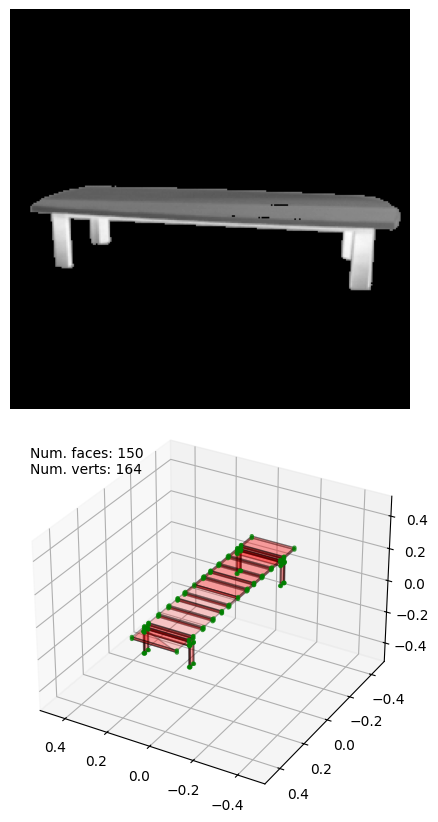

In [6]:
mesh_list = []
for batch in range(min(n_samples, batch_size)):
    mesh_list.append(
        {
        'vertices': vertex_samples['vertices'][batch][:vertex_samples['num_vertices'][batch]].cpu(),
        'faces': data_utils.unflatten_faces(
            face_samples['faces'][batch][:face_samples['num_face_indices'][batch]].cpu())
        }
    )


fig = data_utils.plot_meshes(mesh_list, ax_lims=0.5, return_fig=True) #, 0, projection='3d')
fig_size = 4

n_rows = 1
scale = 1.0
fig_adjusted_height = fig_size * (n_rows + scale)  # Increase the height slightly more for larger images
fig.set_figheight(fig_adjusted_height)

# Adjust positions of existing mesh axes to make space for larger images
for ax in fig.axes:
    pos = ax.get_position()
    # Adjust the bottom position more significantly to make space for larger images
    new_bottom = pos.y0 - (scale / n_rows)  # Increase the offset for the bottom position
    new_bottom = max(new_bottom, 0)
    # Optionally adjust the height of the mesh plots if needed
    #new_height = pos.height * 0.85  # Adjust based on your needs
    ax.set_position([pos.x0, new_bottom, pos.width, pos.height])

# Now add your image axes above the mesh plots
for batch in range(min(n_samples, batch_size)):
    # Calculate position for the new image axes
    mesh_ax = fig.axes[batch]
    mesh_pos = mesh_ax.get_position()

    image_height = mesh_pos.height #* 1.2  # Adjust this multiplier based on desired image size
    image_bottom = mesh_pos.y0 + mesh_pos.height - (image_height - mesh_pos.height)
    image_pos = [mesh_pos.x0, mesh_pos.y0 + mesh_pos.height, mesh_pos.width, mesh_pos.height / n_rows]
    
    # Create new axes for the image
    axins = fig.add_axes(image_pos)
    image = inp['image'][batch].clone() 
    if inp['image'][batch].shape[0] == 3:
        cmap=None
    else:
        cmap='gray'
    axins.imshow(image.permute(1,2,0).cpu(), cmap='gray')
    axins.axis('off')
